# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 1. Полносвязные нейронные сети.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить полносвязную нейронную сеть для предсказания года выпуска песни по ее аудио-признакам. Для этого мы будем использовать [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html).

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

plt.rcParams.update({"font.size": 16})
sns.set_style("whitegrid")
np.random.seed(0xFA1AFE1)

Начнем с того, что скачаем и загрузим данные:

In [29]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2025-04-06 08:56:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [        <=>         ] 201.24M  5.21MB/s    in 28s     

2025-04-06 08:57:11 (7.07 MB/s) - ‘data.txt.zip’ saved [211011981]



In [30]:
df = pd.read_csv("data.txt.zip", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2006,51.28467,45.88068,22.19582,-5.53319,-3.61835,-16.36914,2.12652,5.18160,-8.66890,...,4.81440,-3.75991,-30.92584,26.33968,-5.03390,21.86037,-142.29410,3.42901,-41.14721,-15.46052
515341,2006,49.87870,37.93125,18.65987,-3.63581,-27.75665,-18.52988,7.76108,3.56109,-2.50351,...,32.38589,-32.75535,-61.05473,56.65182,15.29965,95.88193,-10.63242,12.96552,92.11633,10.88815
515342,2006,45.12852,12.65758,-38.72018,8.80882,-29.29985,-2.28706,-18.40424,-22.28726,-4.52429,...,-18.73598,-71.15954,-123.98443,121.26989,10.89629,34.62409,-248.61020,-6.07171,53.96319,-8.09364
515343,2006,44.16614,32.38368,-3.34971,-2.49165,-19.59278,-18.67098,8.78428,4.02039,-12.01230,...,67.16763,282.77624,-4.63677,144.00125,21.62652,-29.72432,71.47198,20.32240,14.83107,39.74909


Посмотрим на статистики по данным.

In [31]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [32]:
len(df[0].unique())

89

Целевая переменная, год выпуска песни, записана в первом столбце. Посмотрим на ее распределение.

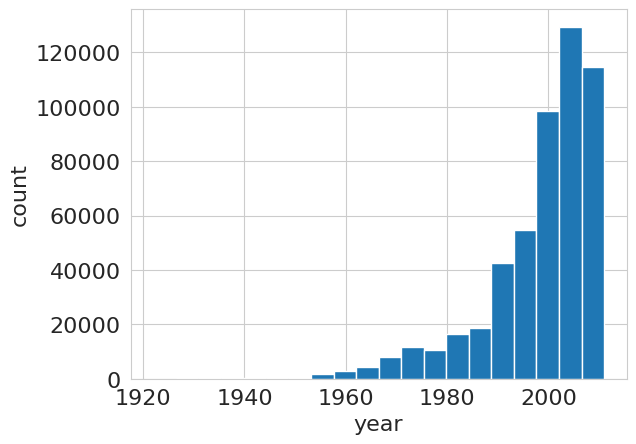

Range: 1922 - 2011
Unique values: 89


In [33]:
plt.hist(df.iloc[:, 0], bins=20)
plt.xlabel("year")
plt.ylabel("count")
plt.show()
print(f"Range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}")
print(f"Unique values: {np.unique(df.iloc[:, 0]).size}")

Разобьем данные на обучение и тест (не меняйте здесь ничего, чтобы сплит был одинаковым у всех).

In [34]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = int(0.75 * X.shape[0])
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
X_train.shape, X_test.shape

((386508, 90), (128837, 90))

**Задание 0 (0 баллов, но при невыполнении максимальная оценка за всю работу &mdash; 0 баллов).** Мы будем использовать MSE как метрику качества. Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы. Для этого бучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе (также пропишите текстом, какая константа будет лучшей для MSE).

In [35]:
ridge = Ridge(alpha=0.1)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred)

In [36]:
# поэксперементируем константами: возьмем среднее, моду и медиану

mean = np.mean(y_train)
median = np.median(y_train)

unic_val, count_val = np.unique(y_train, return_counts=True)
index = np.argmax(count_val)
mode = unic_val[index]

y_pred_mean = np.full_like(y_test, mean)
y_pred_median = np.full_like(y_test, median)
y_pred_mode = np.full_like(y_test, mode)

mse_mean = mean_squared_error(y_test, y_pred_mean)
mse_median = mean_squared_error(y_test, y_pred_median)
mse_mode = mean_squared_error(y_test, y_pred_mode)

In [37]:
mse_ridge, mse_mean, mse_median, mse_mode

(89.74966389498053, 117.83191164028968, 130.13409191458976, 190.51181725746486)

**Ответ:** Для ридж регрессии с регуляризацией альфа = 0.1, значение MSE составил 89.7.

Для константного прогноза наилучший результат показал прогноз по среднему значению таргета: MSE = 117.8. В целом, регерссионная модель

Теперь приступим к экспериментам с нейросетями. Для начала отделим от данных валидацию:

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=0xE2E4
)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

## Глава I. Заводим нейронную сеть (5 баллов)

**Задание 1.1 (0.5 баллов).** Заполните пропуски в функции `train_and_validate`. Она поможет нам запускать эксперименты. Можете также реализовать поддержку обучения на GPU, чтобы эксперименты считались быстрее. Бесплатно воспользоваться GPU можно на сервисах **Google Colab** и **Kaggle**.

In [12]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("MSE")
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
    device='cpu'
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    """
    model.to(device)

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

**Задание 1.2 (0.75 балла).** Попробуем обучить нашу первую нейронную сеть. Здесь целевая переменная дискретная &mdash; это год выпуска песни. Поэтому будем учить сеть на классификацию c помощью [кросс-энтропийной функции потерь](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

- В качестве архитектуры сети возьмите два линейных слоя с активацией ReLU между ними c числом скрытых нейронов, равным 128.
- Используйте SGD с `lr=1e-2`.
- Возьмите размер мини-батча около 32-64, примерно 3-4 эпох обучения должно быть достаточно.
- Скорее всего вам пригодится `torch.utils.data.TensorDataset`. Когда будете конвертировать numpy-массивы в torch-тензоры, используйте тип `torch.float32`.
- Также преобразуйте целевую переменную так, чтобы ее значения принимали значения от $0$ до $C-1$, где $C$ &mdash; число классов (лучше передайте преобразованное значение в TensorDataset, исходное нам еще пригодится)
- В качестве параметра `metric` в `train_and_validate` передайте lambda-выражение, которое считает MSE по выходу нейронной сети и целевой переменной. В случае классификации предсказывается класс с наибольшей вероятностью (или, что то же самое, с наибольшим значением **логита**$^1$).

$^1$ **Логит** &mdash; выход последнего линейного слоя, может принимать любые вещественные значения. Если применить Softmax к логитам, то получатся вероятности распределения классов.

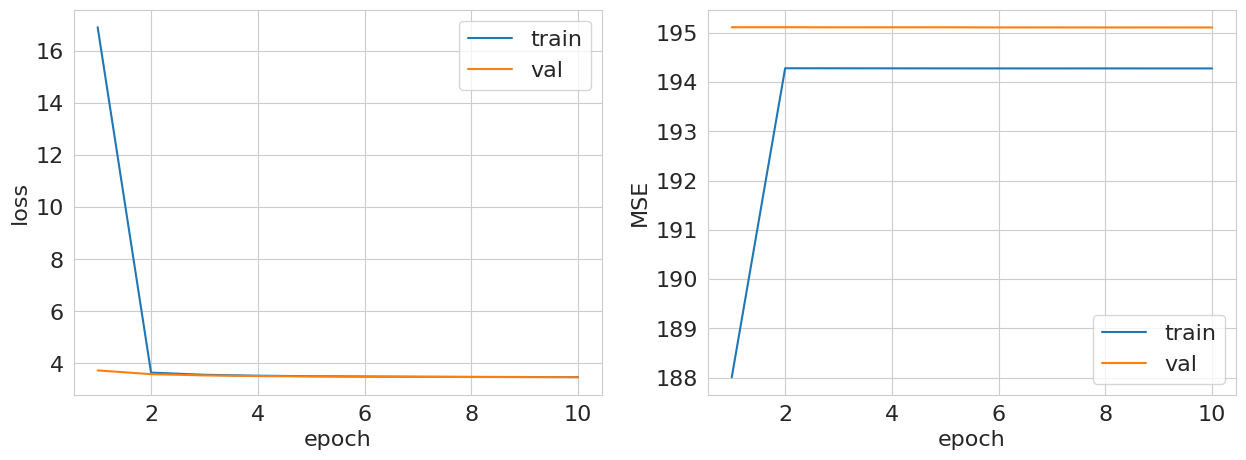

Validation MSE: 195.107


In [ ]:
class NNModel(nn.Module):
  def __init__(self):
    super(NNModel, self).__init__()
    self.fc1 = nn.LazyLinear(128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 89)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

nn_regr = NNModel()

optimizer = torch.optim.SGD(nn_regr.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

metric = lambda preds, targets: ((torch.argmax(preds, dim=1) - targets.float()) ** 2).mean()

year_to_index = {year: idx for idx, year in enumerate(np.unique(y_train))}

y_train_year = [year_to_index[year] for year in y_train]
y_val_year = [year_to_index[year] for year in y_val]

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                     torch.tensor(y_train_year, dtype=torch.long))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_year, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                10,
                                True,
                                device='cuda')

**Задание 1.3 (0.5 балла).** Прокомментируйте ваши наблюдения. Удалось ли побить бейзлайн? Как вы думаете, хорошая ли идея учить классификатор для этой задачи? Почему?

**Ответ:** MSE нейронной сети на валидационной выборке получился хуже чем бейзлайн и любое из предсказаний константой. Обучение ведет себя не совсем адекватно (рост потерь на трейне). Определенно нужен подбор гиперпараметров. Плюс когда целых 89 классов наверное надо регуляризировать и использовать более сложные архитектуры.

**Задание 1.4 (0.75 балла).** Теперь попробуем решать задачу как регрессию. Обучите нейронную сеть на [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

- Используйте такие же гиперпараметры обучения.
- Когда передаете целевую переменную в TensorDataset, сделайте reshape в (-1, 1).
- Не забудьте изменить lambda-выражение, которые вы передаете в `train_and_validate`.
- Если что-то пойдет не так, можете попробовать меньшие значения `lr`.

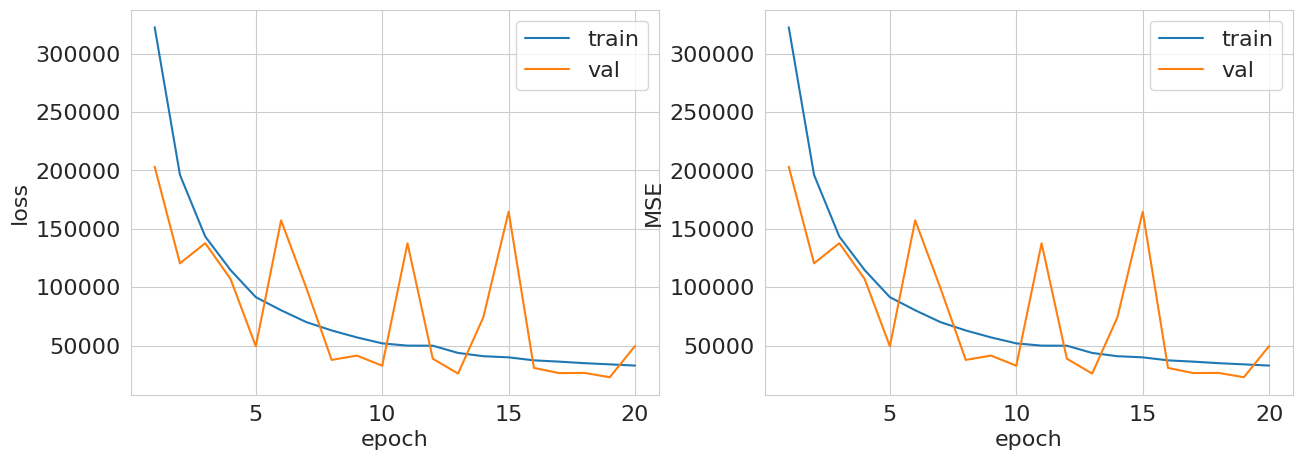

Validation MSE: 49591.536


In [ ]:
class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.SGD(nn_regr.parameters(), lr=1e-8)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((preds - targets) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                20,
                                True,
                                device='cuda')

**Задание 1.5 (0.5 балла).** Получилось ли у вас стабилизировать обучение? Помогли ли меньшие значения `lr`? Стало ли лучше от замены классификации на регрессию? Как вы думаете, почему так происходит? В качестве подсказки можете посмотреть на распределение целевой переменной и магнитуду значений признаков.

**Ответ:** Обучение стабильное, но ошибка высокая. MSE получился в районе 50000, что выше чем в классификации и в бэйзлайн моделях. По всей видимости это связано с тем, что вариация переменной очень низкая, а абсолютное значение высокое (что логично, поскольку основная часть треков была выпущена после 2000 года, когда началось развитие медиа и портативных устройств для прослушивания музыки).

**Задание 1.6 (0.75 балла).** Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1. Реализуйте функции `normalize` и `denormalize`, которые, соответственно, нормируют целевую переменную и применяют обратное преобразование. Минимум и максимум оцените по обучающей выборке (то есть эти константы должны быть фиксированными и не зависеть от передаваемой выборки).

In [26]:
scaler = MinMaxScaler()

scaler.fit(y_train.reshape(-1, 1))

def normalize(sample):
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return scaler.transform(sample.reshape(-1, 1)).flatten()


def denormalize(sample):
    """
    Denormalize sample from [0, 1] to initial range
    """
    return scaler.inverse_transform(sample.reshape(-1, 1)).flatten()

Теперь повторите эксперимент из **задания 1.4**, обучаясь на нормированной целевой переменной. Сделаем также еще одно изменение: добавим [сигмоидную активацию](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) после последнего линейного слоя сети. Таким образом мы гарантируем, что нейронная сеть предсказывает числа из промежутка $[0, 1]$. Использование активации - довольно распространенный прием, когда мы хотим получить числа из определенного диапазона значений.

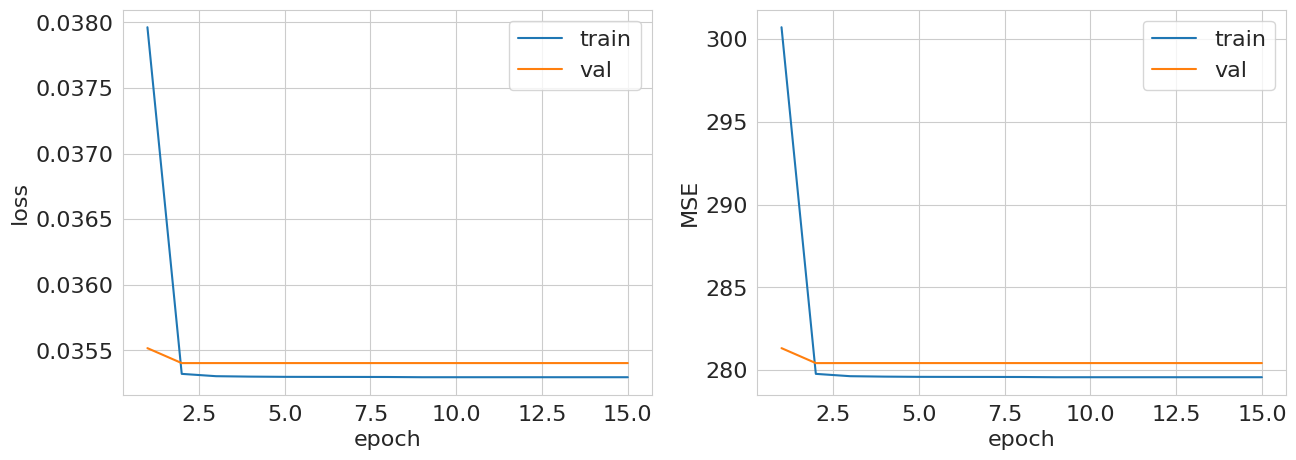

Validation MSE: 280.428


In [ ]:
y_train_norm = normalize(y_train)
y_val_norm = normalize(y_val)

class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.SGD(nn_regr.parameters(), lr=1e-4)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                15,
                                True,
                                device='cuda')

**Задание 1.7 (0.5 балла).** Сравните результаты этого эксперимента с предыдущим запуском.

**Ответ:** Качество предсказания значительно улучшилось. MSE упал с 50000 до около 280. Однако это все равно хуже бейзлайна. Продолжаем эксперименты

**Задание 1.8 (0.75 балла).** На этот раз попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение. Преобразуйте данные и повторите прошлый эксперимент. Скорее всего, имеет смысл увеличить число эпох обучения.

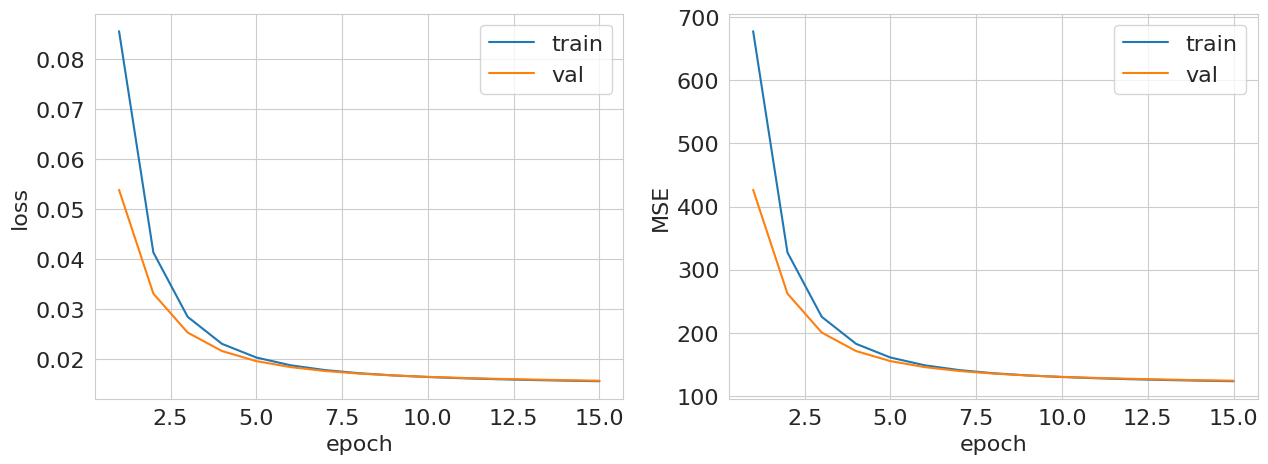

Validation MSE: 124.017


In [27]:
scaler_x = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)

y_train_norm = normalize(y_train)
y_val_norm = normalize(y_val)

class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.SGD(nn_regr.parameters(), lr=1e-4)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                15,
                                True,
                                device='cuda')

**Ответ:** По итогу значение MSE получилось 124 что в целос сопоставимо с Ридж регрессией - 90.

Если вы все сделали правильно, то у вас должно было получиться качество, сравнимое с `Ridge` регрессией.

**Мораль:** как видите, нам пришлось сделать очень много хитрых телодвижений, чтобы нейронная сеть работала хотя бы так же, как и простая линейная модель. Здесь, конечно, показан совсем экстремальный случай, когда без нормализации данных нейронная сеть просто не учится. Как правило, в реальности завести нейронную сеть из коробки не очень сложно, но вот заставить ее работать на полную &mdash; куда более трудоемкая задача. Написание пайплайнов обучения нейросетевых моделей требует большой аккуратности, а дебаг часто превращается в угадайку. К счастью, очень часто на помощь приходит интуиция, и мы надеемся, что вы сможете выработать ее в течение нашего курса. Начнем с двух советов, которые стоит принять на вооружение:

- Обязательно начинаем любые эксперименты с бейзлайнов: без них мы бы не поняли, что нейронная сеть не учится в принципе.
- При постановке эксперментов старайтесь делать минимальное количество изменений за раз (в идеале одно!): только так можно понять, какие конкретно изменения влияют на результат.

## Часть 2. Улучшаем нейронную сеть (5 баллов)

Продолжим экспериментировать с нейронной сетью, чтобы добиться еще лучшего качества.

**Задание 2.1 (1 балл).** Давайте попробуем другие оптимизаторы. Обучите нейросеть с помощью SGD+momentum и Adam. Опишите свои наблюдения и в дальнейших запусках используйте лучший оптимизатор. Для Adam обычно берут learning rate поменьше, в районе $10^{-3}$.

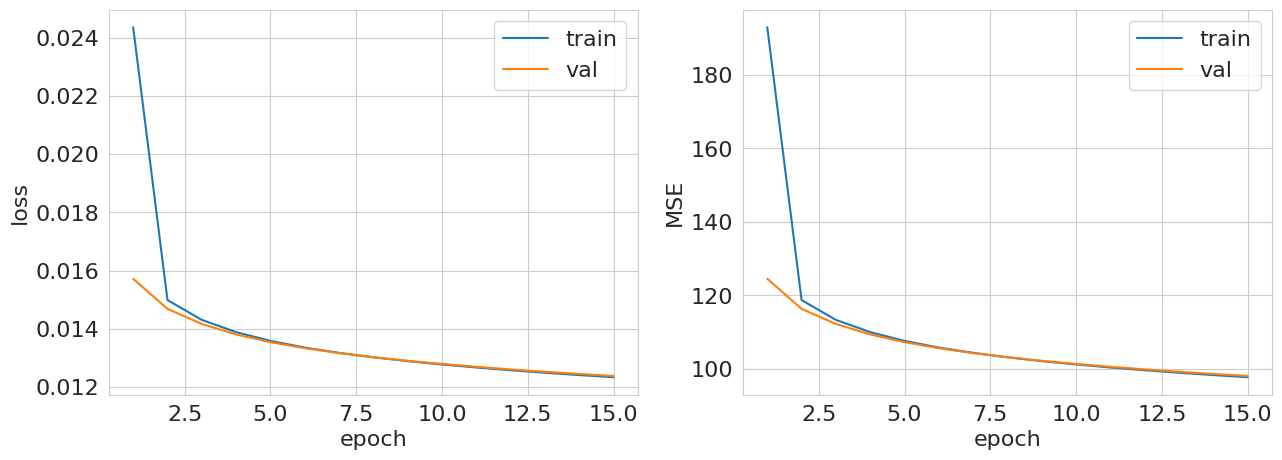

Validation MSE: 98.093


In [39]:
scaler_x = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)

y_train_norm = normalize(y_train)
y_val_norm = normalize(y_val)

class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.SGD(nn_regr.parameters(), lr=1e-4, momentum=0.9)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                15,
                                True,
                                device='cuda')

**Ответ:** SGD + momentum позволили существенно улучшить качество модели и снизить MSE со 124 до 98 еще сильнее приблизив к бейзлайн.

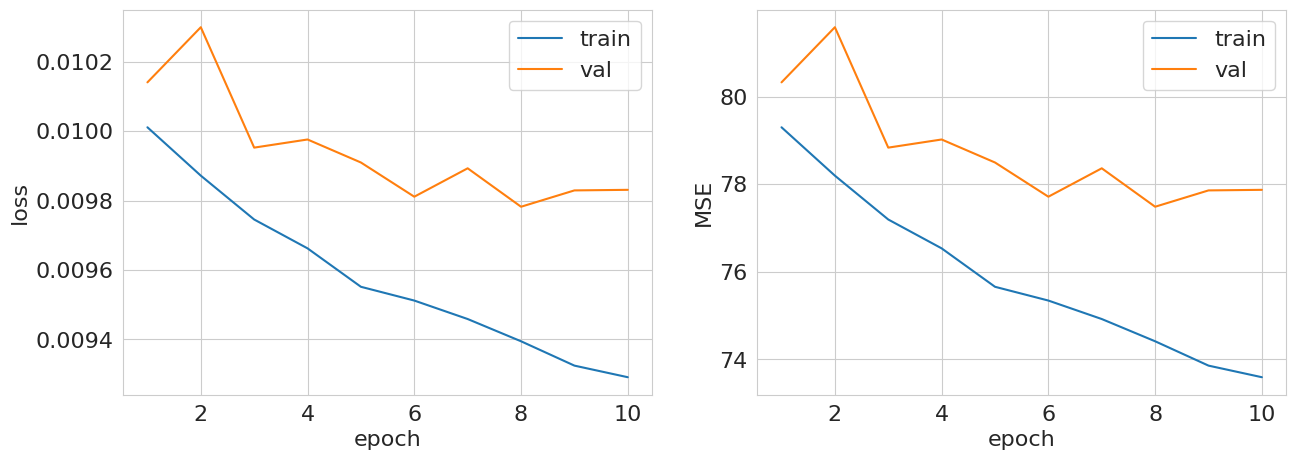

Validation MSE: 77.870


In [41]:
optimizer = torch.optim.Adam(nn_regr.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-7)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                10,
                                True,
                                device='cuda')

**Ответ:** Применение оптимизатора Adam позволило превзойти результаты бейзлайна, MSE = 78.

**Задание 2.2 (1 балл).** Теперь сделаем нашу нейронную сеть более сложной. Попробуйте сделать сеть:

- более широкой (то есть увеличить размерность скрытого слоя, например, вдвое)
- более глубокой (то есть добавить еще один скрытый слой)

Опишите, как увеличение числа параметров модели влияет на качество на обучающей и валидационной выборках.

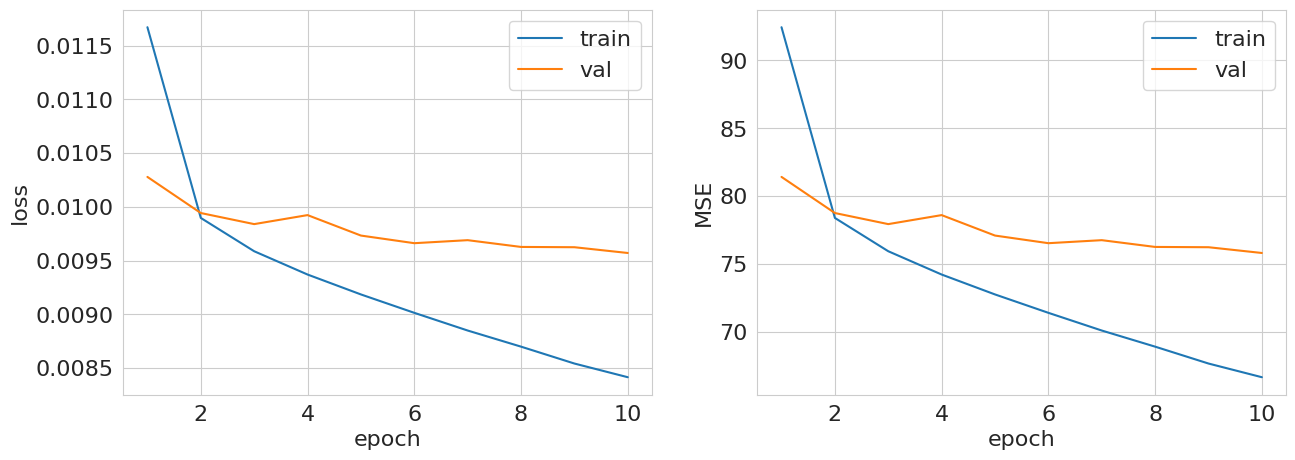

Validation MSE: 75.811


In [43]:
class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.Adam(nn_regr.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-7)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                10,
                                True,
                                device='cuda')

**Ответ:** усложнение архитектуры нейронной сети: добавление в нее дополнительного слоя и увеличение количества нейронов промежуточного слоя до 256 дало снижение MSE с 78 до 76. Однако стал заметен рост переобучения: разница межу MSE на тренировочной и валидационной выборке начала увеличиваться.

**Задание 2.3 (1 балл).** Как вы должны были заметить, более сложная модель стала сильнее переобучаться. Попробуем добавить в обучение регуляризацию, чтобы бороться с переобучением. Добавьте слой дропаута ([`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)) с параметром $p=0.2$ после каждого линейного слоя, кроме последнего. Почитать про дропаут можете в следующем [блогпосте](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) или в оригинальной [статье](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

Опишите результаты.

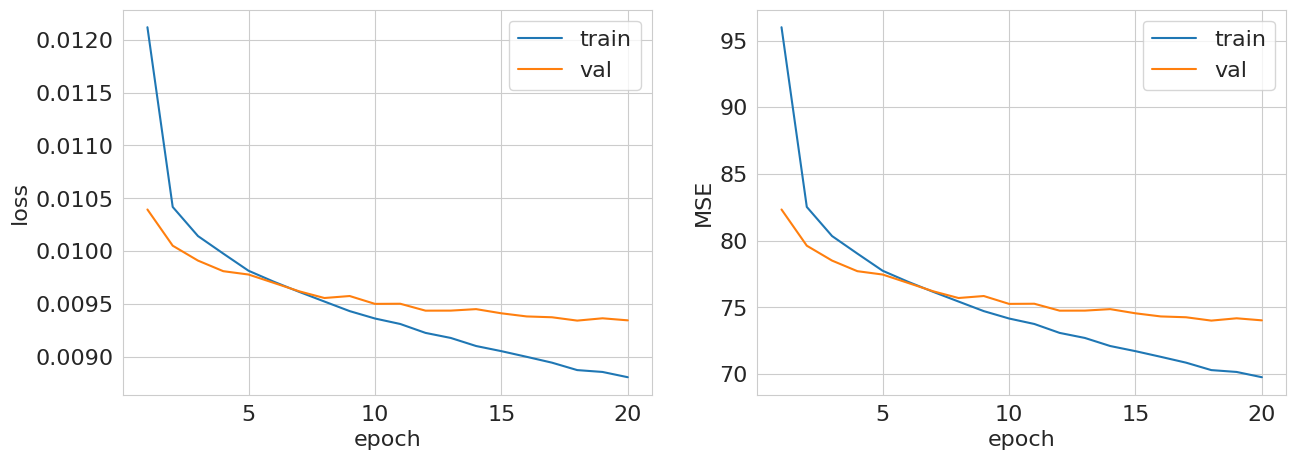

Validation MSE: 74.017


In [45]:
class NNModelRegression(nn.Module):
    def __init__(self):
        super(NNModelRegression, self).__init__()
        self.fc1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

nn_regr = NNModelRegression()

optimizer = torch.optim.Adam(nn_regr.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-7)
criterion = nn.MSELoss()

metric = lambda preds, targets: ((denormalize(preds.cpu()) - denormalize(targets.cpu())) ** 2).mean()

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train_norm, dtype=torch.float32).reshape(-1, 1))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val_norm, dtype=torch.float32).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

nn_metrics = train_and_validate(nn_regr,
                                optimizer,
                                criterion,
                                metric,
                                train_loader,
                                val_loader,
                                20,
                                True,
                                device='cuda')

**Задание 2.4 (1.5 балла).** Теперь, когда мы определились с выбором архитектуры нейронной сети, пора заняться рутиной DL-инженера &mdash; перебором гиперпараметров. Подберите оптимальное значение lr по значению MSE на валидации (по логарифмической сетке, достаточно посмотреть 3-4 значения), можете воспользоваться `verbose=False` в функции `train_and_validate`.

Также подберем оптимальное значение параметра weight decay для данного lr. Weight decay &mdash; это аналог L2-регуляризации для нейронных сетей. Почитать о нем можно, например, [здесь](https://paperswithcode.com/method/weight-decay). В PyTorch он задается как параметр оптимизатора `weight_decay`. Подберите оптимальное значение weight decay по логарифимической сетке (его типичные значения лежат в диапазоне $[10^{-6}, 10^{-3}]$, но не забудьте включить нулевое значение в сетку).

Постройте графики зависимости MSE на трейне и на валидации от значений параметров. Прокомментируйте получившиеся зависимости.

In [ ]:
# отключим отрисовку графиков



Как вы могли заметить, еще одна рутина DL-инженера &mdash; утомительное ожидание обучения моделей.

**Задание 2.5 (0.5 балла).** Мы провели большое число экспериментов и подобрали оптимальную архитектуру и гиперпараметры. Пришло время обучить модель на полной обучающей выборке, померять качество на тестовой выборке и сравнить с бейзлайнами. Проделайте это.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ